In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import folium
from folium import GeoJson
from folium.features import GeoJsonTooltip, CustomIcon

In [2]:
# Load the shapefile
file_path = "/content/drive/MyDrive/Colab/LTS/BOS_streets/boston_streets.shp"
gdf = gpd.read_file(file_path)

gdf.shape

(36863, 217)

In [3]:
# Inspect the categories of the FEDERALFUN attribute
gdf["FEDERALFUN"].value_counts(dropna=False)

,count
FEDERALFUN,
7,14487
0,9230
3,4965
4,3205
5,2605
2,823
6,798
1,750


In [4]:
# Helper function to calc. the number of through lanes per direction (qDirLanes)
def calculate_qDirLanes(row):
    if row['StOperNEU'] in (1, 11, 21):  # one-way street
        return max(row['Lanes_OW'], 1)
    elif row['FEDERALFUN'] == 7:         # two-way local street
        return (max(row['NUMLANE'], 2) / 2) if row['Has_CL'] else 0
    elif row['No_CL'] == 1:              # two-way local street w/o centerline
        return 0
    else:                                # Default for two-way streets with centerline
        return max(row['NUMLANE'], 2) / 2

gdf['qDirLanes'] = gdf.apply(calculate_qDirLanes, axis=1)

In [5]:
# Helper function to calc. the prevailing speed of the road segment (SPEED)
def calculate_speed(row):
    # Base speed logic
    if (row['FEDERALFUN'] == 7 and row['Has_CL'] == 0) or \
       (row['FEDERALFUN'] < 7 and row['No_CL'] == 1):
        spd = 25
    elif row['SPD_MDOT'] > 0:
        spd = row['SPD_MDOT']
    else:
        spd = 30

    # Apply speed rule adjustments
    if row['Speed_Rule'] is not None:
        if row['Speed_Rule'][:3] == "ABS":
            spd = int(row['Speed_Rule'][4:6])
        elif row['Speed_Rule'][:3] == "ADD":
            spd += int(row['Speed_Rule'][4:6])

    return spd

gdf['SPEED'] = gdf.apply(calculate_speed, axis=1)

In [6]:
# Helper function to calc. ADT (ADT_Infer)
def calculate_ADT_Infer(row):
    if row['FEDERALFUN'] == 7:            # local street
        if row['StOperNEU'] in (0, 2):    # two-way street
            if row['GT30L'] == 1:
                return 3001
            elif row['GT15L'] == 1:
                return 1501
            else:
                return 1499
        else:                             # one-way street
            if row['GT20LO'] == 1:
                return 3001
            elif row['GT10LO'] == 1:
                return 1501
            else:
                return 1499
    elif row['qDirLanes'] <= 1:
        if row['StOperNEU'] in (0, 2):
            if row['LT15'] == 1:
                return 1499
            elif row['LT30'] == 1:
                return 2999
            else:
                return 3001
        else:
            if row['LT10NO1'] == 1:
                return 1499
            elif row['LT20NO1'] == 1:
                return 2999
            else:
                return 3001
    elif row['qDirLanes'] >= 2:
        if row['StOperNEU'] in (0, 2):
            if row['LT802P2'] == 1:
                return 7999
            else:
                return 8001
        else:
            if row['LT56O2'] == 1:
                return 7999
            else:
                return 8001

gdf['ADT_Infer'] = gdf.apply(calculate_ADT_Infer, axis=1)

In [7]:
# Calculate LTS
def calculate_LTS(row):
    # Check special cases
    if row['qNoAccess'] == 1:        # Freeway
        return 6
    elif row['qExclude'] == 1:       # Private property
        return 5
    elif row['FEDERALFUN'] == 0 and row['qExclude'] == 0:
        return 1
    elif row['qProtected'] == 1:     # Off-road path or cycle track
        return 1

    # Mixed Traffic conditions
    if (row['BL_WIDTH'] < 4) or \
       ((row['BL_WIDTH'] >= 4) and (row['ILLPARKING'] == 1)) or \
       ((row['BL_WIDTH'] >= 4) and (row['PARKALONG'] > 0) and (row['BL_REACH'] <= 12)):

        # Determine LTS for Mixed Traffic
        if ((row['qDirLanes'] >= 3 and row['SPEED'] >= 30) or
            (row['qDirLanes'] == 2 and row['ADT_Infer'] > 8000 and row['SPEED'] >= 30) or
            (row['qDirLanes'] == 2 and row['ADT_Infer'] <= 8000 and row['SPEED'] >= 40) or
            (row['qDirLanes'] == 1 and row['ADT_Infer'] > 1500 and row['SPEED'] >= 40) or
            (row['qDirLanes'] == 1 and row['ADT_Infer'] > 750 and row['SPEED'] >= 50) or
            (row['qDirLanes'] == 0 and row['ADT_Infer'] > 1500 and row['SPEED'] >= 40) or
            (row['qDirLanes'] == 0 and row['ADT_Infer'] > 750 and row['SPEED'] >= 50)):
            return 4
        elif ((row['qDirLanes'] >= 2) or
              (row['SPEED'] >= 40) or
              (row['qDirLanes'] == 1 and row['ADT_Infer'] > 3000) or
              (row['qDirLanes'] == 1 and row['ADT_Infer'] > 1500 and row['SPEED'] >= 25) or
              (row['qDirLanes'] == 1 and row['ADT_Infer'] > 750 and row['SPEED'] >= 35) or
              (row['qDirLanes'] == 0 and row['ADT_Infer'] > 3000 and row['SPEED'] >= 25) or
              (row['qDirLanes'] == 0 and row['ADT_Infer'] > 750 and row['SPEED'] >= 35)):
            return 3
        elif ((row['qDirLanes'] == 1 and row['ADT_Infer'] > 750) or
              (row['qDirLanes'] == 1 and row['SPEED'] >= 30) or
              (row['qDirLanes'] == 0 and row['ADT_Infer'] > 1500) or
              (row['qDirLanes'] == 0 and row['SPEED'] >= 30)):
            return 2
        elif ((row['qDirLanes'] == 1 and row['SPEED'] <= 25) or
              (row['qDirLanes'] == 0 and row['SPEED'] <= 25)):
            return 1
        else:
            return 6

    # Bike lane with no adjacent parking
    if (row['BL_WIDTH'] >= 4 and row['PARKALONG'] == 0):
        if ((row['qDirLanes'] >= 3 and row['SPEED'] >= 40) or
            (row['qDirLanes'] == 2 and row['SPEED'] >= 50 and row['BL_WIDTH'] < 6) or
            (row['qDirLanes'] <= 1 and row['SPEED'] >= 50 and row['BL_WIDTH'] < 6)):
            return 4
        elif ((row['qDirLanes'] >= 3) or (row['SPEED'] >= 40)):
            return 3
        elif ((row['qDirLanes'] == 2) or
              (row['SPEED'] >= 30) or
              (row['qDirLanes'] <= 1 and row['BL_WIDTH'] < 6)):
            return 2
        elif ((row['qDirLanes'] <= 1) and (row['BL_WIDTH'] >= 6)):
            return 1
        else:
            return 99

    # Bike lane adjacent to parking
    if (row['BL_WIDTH'] >= 4 and row['PARKALONG'] == 1 and row['BL_REACH'] >= 12):
        if row['SPEED'] >= 40:
            return 4
        elif ((row['qDirLanes'] <= 1 and row['SPEED'] <= 25 and row['BL_REACH'] >= 15) or
              (row['qDirLanes'] <= 1 and row['SPEED'] <= 30) or
              (row['qDirLanes'] <= 2 and row['SPEED'] <= 25 and row['BL_REACH'] >= 15) or
              (row['qDirLanes'] <= 3 and row['SPEED'] <= 25 and row['StOperNEU'] == 1 and row['BL_REACH'] >= 15)):
            return 2
        elif (row['SPEED'] >= 35 or row['qDirLanes'] >= 2):
            return 3
        else:
            return 98

    # Default case
    return 97

# Apply the LTS calculation to the DataFrame
gdf['LTS'] = gdf.apply(calculate_LTS, axis=1)

In [8]:
gdf["qLTS_Own"].value_counts()

,count
qLTS_Own,
1,13034
0,7418
5,5624
3,4639
4,2458
2,1909
6,1781


In [9]:
gdf["LTS"].value_counts()

,count
LTS,
1,12321
3,8273
2,6773
5,6059
6,1882
4,1555


In [10]:
# Create a mismatch column
gdf['Mismatch'] = gdf['LTS'] != gdf['qLTS_Own']

# Count total mismatches
total_mismatches = gdf['Mismatch'].sum()

# Calculate the mismatch percentage
total_instances = len(gdf)
mismatch_percentage = (total_mismatches / total_instances) * 100

print(f"Total Mismatches: {total_mismatches}")
print(f"Mismatch Percentage: {mismatch_percentage:.2f}%")

Total Mismatches: 13770
Mismatch Percentage: 37.35%


In [11]:
# Define the range of interest (ignore LTS 0, LTS 99, LTS 97)
valid_range = {1, 2, 3, 4, 5, 6}

# Filter rows where both LTS and qLTS_Own are within the valid range
gdf['Mismatch2'] = gdf.apply(lambda row: (row['LTS'] != row['qLTS_Own'])
                            if row['LTS'] in valid_range and row['qLTS_Own'] in valid_range else False, axis=1)

# Count total mismatches within the valid range
total_mismatches = gdf['Mismatch2'].sum()

# Calculate the mismatch percentage based on valid rows
valid_instances = gdf[(gdf['LTS'].isin(valid_range)) & (gdf['qLTS_Own'].isin(valid_range))].shape[0]
mismatch_percentage = (total_mismatches / valid_instances) * 100 if valid_instances > 0 else 0

print(f"Total Mismatches (within range 1-6): {total_mismatches}")
print(f"Mismatch Percentage (within range 1-6): {mismatch_percentage:.2f}%")

Total Mismatches (within range 1-6): 6352
Mismatch Percentage (within range 1-6): 21.57%


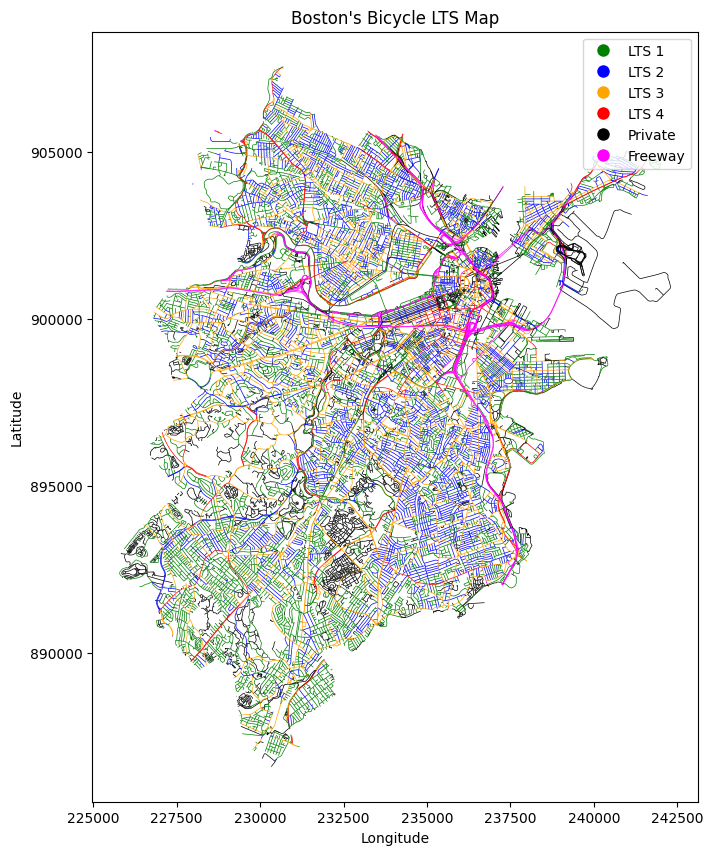

In [12]:
# Treat 'LTS' as categorical
gdf['LTS'] = gdf['LTS'].astype('category')

# Define a custom color map
color_map = {
    1: 'green',    # LTS 1
    2: 'blue',     # LTS 2
    3: 'orange',   # LTS 3
    4: 'red',      # LTS 4
    5: 'black',    # Private road
    6: 'magenta'   # Freeway or limited-access road
}

# Create a list of colors corresponding to the categories
colors_list = [color_map.get(int(val) + 1, 'gray') for val in gdf['LTS'].cat.codes]

# Plotting the data with categorical colors
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color=colors_list, edgecolor='black', linewidth=0.5)

# Create a custom legend
from matplotlib.lines import Line2D

legend_labels = {
    1: 'LTS 1',
    2: 'LTS 2',
    3: 'LTS 3',
    4: 'LTS 4',
    5: 'Private',
    6: 'Freeway'
}

legend_elements = [Line2D([0], [0], marker='o', color='w', label=legend_labels[k],
                          markerfacecolor=color_map[k], markersize=10) for k in color_map.keys()]
ax.legend(handles=legend_elements, title_fontsize='13')

# Add title and labels
ax.set_title("Boston's Bicycle LTS Map")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Show the plot
plt.show()

In [14]:
# Map colors to the 'LTS' column
gdf['color'] = gdf['LTS'].map(color_map)

# Convert Timestamp columns to strings before creating GeoJson
for col in gdf.select_dtypes(include=['datetime64']).columns:
    gdf[col] = gdf[col].astype(str)  # Convert Timestamp columns to strings

# Create a Folium map centered on Boston
m = folium.Map(location=[42.3601, -71.0589], zoom_start=12)

# JavaScript for adaptive line thickness
adaptive_line_thickness = """
function(feature, layer) {
    var zoom = map.getZoom();
    var weight = zoom >= 14 ? 3 : zoom >= 12 ? 2 : 1;
    layer.setStyle({
        color: feature.properties.color,
        weight: weight,
        opacity: 0.8
    });
}
"""

# Add GeoJson layer with adaptive line thickness
geojson = GeoJson(
    gdf,
    style_function=lambda feature: {
        'color': feature['properties']['color'],
        'weight': 2,
        'opacity': 0.8
    },
    tooltip=GeoJsonTooltip(
        fields=['LTS'],
        aliases=['LTS Level:'],
        sticky=False
    )
).add_to(m)

# Attach JavaScript for line thickness adjustment
m.get_root().html.add_child(folium.Element(f'<script>{adaptive_line_thickness}</script>'))

# Define custom legend with colored boxes using HTML
legend_html = '''
    <div style="position: fixed;
                bottom: 50px; left: 50px; width: 150px; height: auto;
                border:2px solid grey; z-index:9999;
                font-size:14px; background-color:white; padding: 10px;">
    <h4 style="text-align:center; margin-top: 0;">LTS Legend</h4>
    <div><span style="display:inline-block; width:15px; height:15px; background-color:green; margin-right:5px;"></span>LTS 1</div>
    <div><span style="display:inline-block; width:15px; height:15px; background-color:blue; margin-right:5px;"></span>LTS 2</div>
    <div><span style="display:inline-block; width:15px; height:15px; background-color:orange; margin-right:5px;"></span>LTS 3</div>
    <div><span style="display:inline-block; width:15px; height:15px; background-color:red; margin-right:5px;"></span>LTS 4</div>
    <div><span style="display:inline-block; width:15px; height:15px; background-color:black; margin-right:5px;"></span>Private</div>
    <div><span style="display:inline-block; width:15px; height:15px; background-color:magenta; margin-right:5px;"></span>Freeway</div>
    </div>
'''

# Add the legend to the map
m.get_root().html.add_child(folium.Element(legend_html))

# Display the map
m